In [21]:
import pandas as pd

In [22]:
crime = pd.read_csv("crime_weather_preprocessed")
print(crime.columns)
print(crime.shape[0])

Index(['dow', 'hour_of_day', 'offense_date', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'extracted_month', 'extracted_day', 'ucr_desc_numeric',
       'offense_year_numeric', 'time_block_numeric', 'census_tract_numeric',
       'census_block_numeric'],
      dtype='object')
360042


In [23]:
violent_crime_list = [3, 10, 27, 21, 17, 20, 22, 15]
violent_crime = crime[crime['ucr_desc_numeric'].isin(violent_crime_list)]
crime = violent_crime

In [24]:
crime['offense_date'] = pd.to_datetime(crime['offense_date'], errors='coerce')

crime.set_index('offense_date', inplace=True)

In [25]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

crime_time_series['Crime_Count_W'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

crime_time_series = crime_time_series.drop(columns=['offense_date'])

crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W
0,0,3.625000,9.583333,1.000000,3.958333,14.575400,3.077900,33424.247721,0.032808,7.458333,1.625000,24
1,0,4.062500,15.062500,1.000000,10.500000,38.553237,26.076987,33880.796631,0.236467,9.375000,0.812500,16
2,0,3.454545,15.363636,1.000000,18.818182,35.528818,22.552455,34659.472301,0.036149,3.818182,1.181818,11
3,0,4.100000,14.150000,1.000000,24.700000,47.683939,33.774440,35318.562305,0.097835,8.200000,1.000000,20
4,0,4.500000,11.642857,1.571429,14.571429,38.296079,16.888935,36301.868025,0.041339,5.428571,1.285714,14
...,...,...,...,...,...,...,...,...,...,...,...,...
23986,239,6.000000,14.000000,4.000000,15.000000,65.786003,42.295998,48008.269531,0.007874,2.000000,0.000000,1
23987,239,1.000000,11.000000,5.000000,22.000000,66.505997,51.475998,53042.714844,0.086614,6.000000,0.000000,1
23988,239,4.000000,8.000000,6.000000,1.000000,84.505997,67.945999,53905.542969,0.539370,8.000000,2.000000,1
23989,239,2.500000,8.000000,6.000000,10.000000,75.101002,56.966002,54409.406250,0.458661,7.500000,1.500000,2


In [26]:
crime_time_series.columns

Index(['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month',
       'extracted_day', 'temp_max', 'temp_min', 'daylight_duration',
       'precipitation_sum', 'precipitation_hours', 'time_block_numeric',
       'Crime_Count_W'],
      dtype='object')

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def k_fold_cross_validation(model, X, y, k=5, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_metrics = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = []  
    all_y_pred = []  

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    plt.figure(figsize=(12, 8))
    plt.plot(all_y_test, label='Actual Crime Count', color='blue')
    plt.plot(all_y_pred, label='Predicted Crime Count', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Actual vs. Predicted Crime Count (Weekly) - Comprehensive Plot Across {k} Folds')
    plt.xlabel('Combined Test Samples from All Folds')
    plt.ylabel('Crime Count')
    plt.show()

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [28]:
features = ['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month', 
            'extracted_day', 'temp_max', 'temp_min', 'daylight_duration', 
            'precipitation_sum', 'precipitation_hours', 'time_block_numeric']
X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 1.3675640758491354
  Root Mean Squared Error (RMSE): 2.296267653041126
  R² Score: 0.8075246482163627



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 1.3638661942476031
  Root Mean Squared Error (RMSE): 2.2863979736780697
  R² Score: 0.8208501133686829



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 1.3872342642767819
  Root Mean Squared Error (RMSE): 2.3969141313496767
  R² Score: 0.8125898677791737



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 1.393017924135056
  Root Mean Squared Error (RMSE): 2.32501816385936
  R² Score: 0.816542710741696



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 1.3097248853689036
  Root Mean Squared Error (RMSE): 2.262640330939645
  R² Score: 0.8230076609376007

Average MAE across 5 folds: 1.364281468775496
Average RMSE across 5 folds: 2.3134476505735755
Average R² Score across 5 folds: 0.8161030002087031


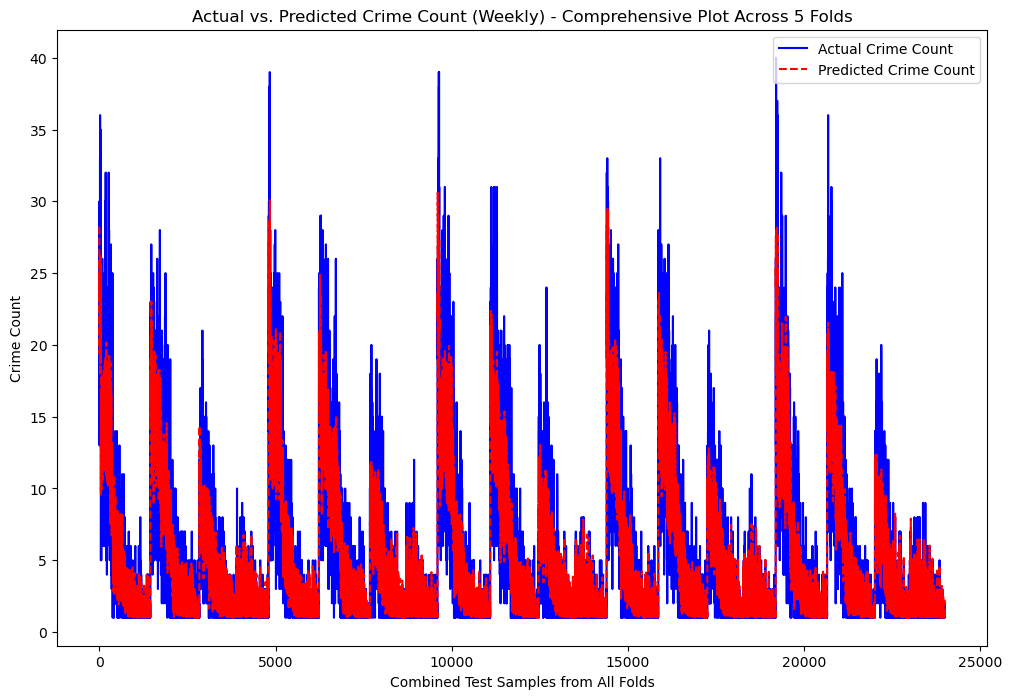

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(rf_model, X, y)

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 1.2979035125961897
  Root Mean Squared Error (RMSE): 2.2062862547693993
  R² Score: 0.8223137855529785



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 1.3078052563629283
  Root Mean Squared Error (RMSE): 2.19907288527566
  R² Score: 0.8342733979225159



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 1.3211034165012832
  Root Mean Squared Error (RMSE): 2.268988120985463
  R² Score: 0.8320605754852295



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 1.3260884415661112
  Root Mean Squared Error (RMSE): 2.22419695187349
  R² Score: 0.8321084976196289



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 1.2598482443546941
  Root Mean Squared Error (RMSE): 2.2129877284048303
  R² Score: 0.8306905031204224

Average MAE across 5 folds: 1.3025497742762415
Average RMSE across 5 folds: 2.222306388261768
Average R² Score across 5 folds: 0.8302893519401551


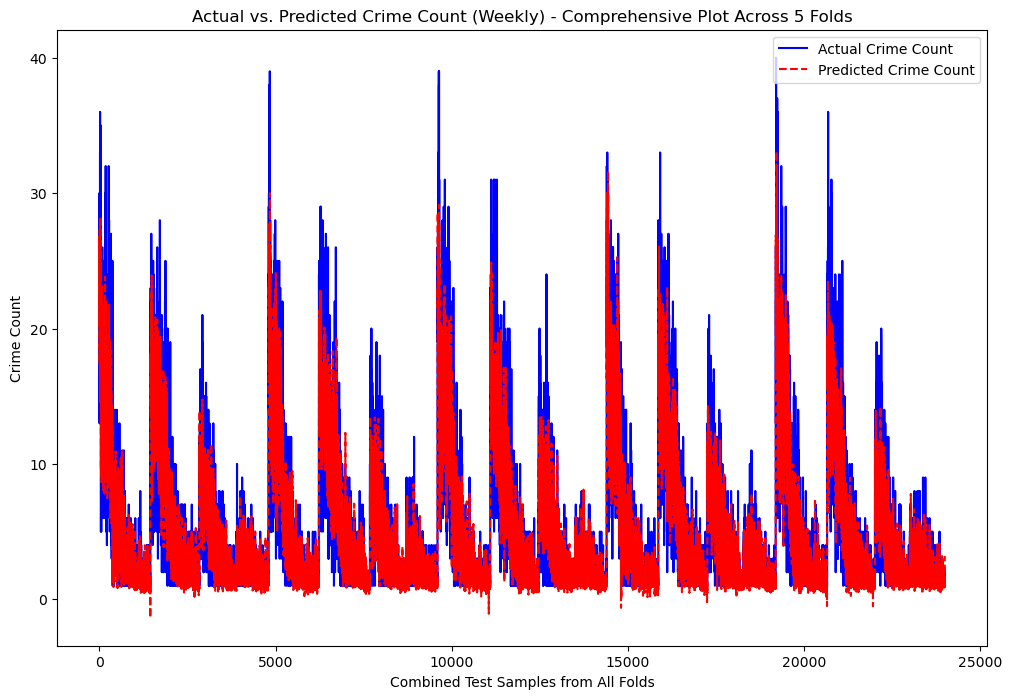

In [30]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(xgb_model, X, y)

In [33]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

timesteps = 24  
features = ['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month', 'extracted_day', 'temp_max', 
            'temp_min', 'daylight_duration', 'precipitation_sum', 'precipitation_hours', 
            'time_block_numeric']
target = 'Crime_Count_W'

scaler = MinMaxScaler()
crime_time_series[features] = scaler.fit_transform(crime_time_series[features])

X = crime_time_series[features].values
y = crime_time_series[target].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_generator = TimeseriesGenerator(X_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_val, y_val, length=timesteps, batch_size=64)

X_transformed, y_transformed = train_generator[0]

C:\Users\singh\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


C:\Users\singh\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 118s 196ms/step - loss: 4.3142 - val_loss: 3.6404 - learning_rate: 5.0000e-04
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 187ms/step - loss: 3.7278 - val_loss: 3.5846 - learning_rate: 5.0000e-04
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 188ms/step - loss: 3.7358 - val_loss: 3.5606 - learning_rate: 5.0000e-04
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 187ms/step - loss: 3.7143 - val_loss: 3.5519 - learning_rate: 5.0000e-04
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - loss: 3.7074 - val_loss: 3.5502 - learning_rate: 5.0000e-04
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 187ms/step - loss: 3.6997 - val_loss: 3.5459 - learning_rate: 5.0000e-04
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - loss: 3.6983 - val_loss: 3.5349 - learning_rate: 5.0000e-04
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - loss: 3.7444 - val_loss: 3.5489 - learning_rate: 5.0000e-04
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 185ms/step - loss: 3.6827 - va

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


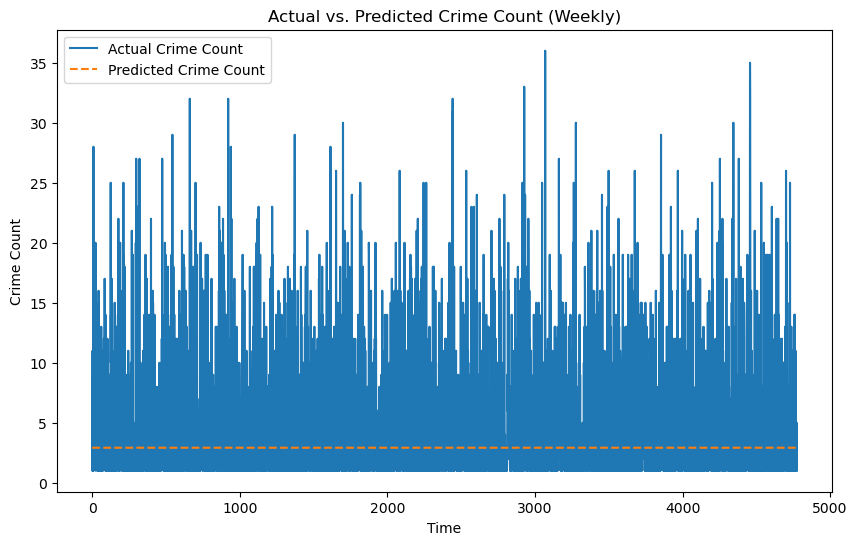

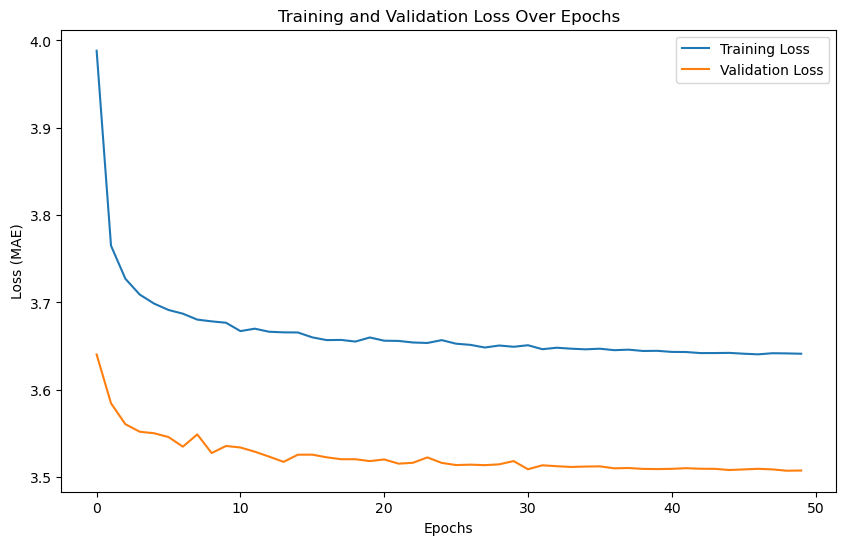

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_model(input_shape):
    model = Sequential([

        LSTM(256, activation='relu', return_sequences=True, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        GRU(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)  
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

input_shape = (timesteps, X_train.shape[1])  # timesteps, features
advanced_model = build_model(input_shape)

history = advanced_model.fit(
    train_generator, 
    epochs=50, 
    validation_data=val_generator, 
    callbacks=[early_stopping, reduce_lr]
)

y_pred = advanced_model.predict(val_generator).flatten()

mae = mean_absolute_error(y_val[timesteps:], y_pred)
rmse = mean_squared_error(y_val[timesteps:], y_pred, squared=False)
r2 = r2_score(y_val[timesteps:], y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_val[timesteps:], label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.show()

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_rnn_model(input_shape):
    model = Sequential([

        SimpleRNN(256, activation='relu', input_shape=input_shape, return_sequences=True, 
                  kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        SimpleRNN(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        SimpleRNN(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        SimpleRNN(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1) 
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mae')
    return model

input_shape = (X_transformed.shape[1], X_transformed.shape[2])  
rnn_model = build_rnn_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=64, 
                        validation_data=(X_val, y_val), verbose=1, 
                        callbacks=[reduce_lr, early_stopping])

y_pred = rnn_model.predict(X_val).flatten()

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.show()

C:\Users\singh\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 11), dtype=float32). Expected shape (None, 24, 11), but input has incompatible shape (None, 11)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 11), dtype=float32)
  • training=True
  • mask=None